In [20]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from mpl_toolkits.mplot3d import Axes3D

In [21]:
S_max = 150 # Maximum Underlying Stock Price
K = 100 # Strike Price
T = 1.0 # (Time to) Maturity
r = 0.05 # Risk-free Rate
sigma0 = 0.2 # Base Volatility
alpha = 0.1 # Fixed terms
beta = 0.05

In [22]:
M = 300          # space grid
N = 2000         # time grid

dS = S_max / M
dt = T / N

S = np.linspace(0, S_max, M + 1)
t = np.linspace(0, T, N + 1)

We construct a grid of points:

- Along the stock axis $S \in [0, S_{\text{max}}]$ with $M + 1$ points  
- Along the time axis** $t \in [0, T]$ with $N + 1$ points

\[
\begin{array}{c|ccccc}
& t_0 & t_1 & t_2 & \cdots & t_N \\
\hline
S_0 & C_{0,0} & C_{0,1} & C_{0,2} & \cdots & C_{0,N} \\
S_1 & C_{1,0} & C_{1,1} & C_{1,2} & \cdots & C_{1,N} \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
S_M & C_{M,0} & C_{M,1} & C_{M,2} & \cdots & C_{M,N} \\
\end{array}
\]

Each $C_{i,n} \approx C(S_i, t_n)$ represents the option price at stock price $S_i$ and time $t_n$.


In [23]:
# initial condition
V = np.maximum(S - K, 0)
solution = np.zeros((N + 1, M + 1))
solution[-1, :] = V.copy()

### Initial Condition Setup for Finite Difference Method

We define the initial condition at maturity $t = T$ using the European call option payoff:

$$
V(S, T) = \max(S - K, 0)
$$

This creates the final time slice in our grid:

- Let $S_0, S_1, \dots, S_M$ be the stock price grid points.
- Let $t_0, t_1, \dots, t_N$ be the time steps, with $t_N = T$.

We store the values in a matrix `solution` of shape $(N+1, M+1)$, where:

- Rows correspond to time steps $t_n$
- Columns correspond to stock prices $S_i$

The following code:

```python
V = np.maximum(S - K, 0)
solution = np.zeros((N + 1, M + 1))
solution[-1, :] = V.copy()
```

means:

$$
\texttt{solution}[N, i] = V(S_i, T) = \max(S_i - K, 0)
$$

This initializes the last row of the solution grid with the terminal payoff condition.


In [24]:
def boundary_conditions(tau):
    left = 0.0
    right = S_max - K * np.exp(-r * (T - tau))
    return left, right

### Boundary Conditions for the Finite Difference Grid

To solve the Black-Scholes PDE using finite differences, we need to define **boundary conditions** along the edges of the stock price domain:

We define the function:

```python
def boundary_conditions(tau):
    left = 0.0
    right = S_max - K * np.exp(-r * (T - tau))
    return left, right
```

- `tau` - current time (moving backward from maturity), i.e. $\tau = t_n$
- `S_{\text{max}}` - maximum stock price (in the discretized grid)
- `K` - strike price
- `r` - risk-free interest rate
- `T` - maturity time

Left Boundary Condition (stock price = 0):

\[
V(0, t) = 0
\]

- If the stock price is zero, the call option is worthless — it will never exceed the strike.
- So we set the left boundary to zero for all time steps.

Right Boundary Condition (stock price = $S_{\text{max}}$):

\[
V(S_{\text{max}}, t) = S_{\text{max}} - K e^{-r(T - t)}
\]

- If the stock price is very high (deep in-the-money), the option behaves like owning the stock minus the present value of the strike.
- This is an approximation of the **intrinsic value** at high stock prices.

Thus, the function returns the boundary values to impose at each time step \( \tau \), where:

- `left` is the option price at \( S = 0 \)
- `right` is the option price at \( S = S_{\text{max}} \)
  
\[
\begin{array}{c|ccccc|c}
& t_0 & t_1 & t_2 & \cdots & t_{N-1} & \color{green}{t_N = T} \\
\hline
S_0     & \color{red}{0} & \color{red}{0} & \color{red}{0} & \cdots & \color{red}{0} & \color{green}{\max(0 - K,\, 0)} \\
S_1     & \cdot & \cdot & \cdot & \cdots & \cdot & \color{green}{\max(S_1 - K,\, 0)} \\
\vdots  & \cdot & \cdot & \cdot & \ddots & \cdot & \color{green}{\vdots} \\
S_{M-1} & \cdot & \cdot & \cdot & \cdots & \cdot & \color{green}{\max(S_{M-1} - K,\, 0)} \\
S_M     & \color{blue}{B_0} & \color{blue}{B_1} & \color{blue}{B_2} & \cdots & \color{blue}{B_{N-1}} & \color{green}{\max(S_M - K,\, 0)} \\
\end{array}
\]


---

Legend:

- 🔴 - Left boundary condition — $ V(0, t_n) = 0 $ 
- 🔵 - Right boundary condition — $ V(S_{\text{max}}, t_n)  = S_{\text{max}} - K e^{-r(T - t_n)} $ 
- 🟢 - Initial condition at maturity $  V(S_i, T) = \max(S_i - K, 0)  $


In [25]:
def local_vol(S, tau):
    sig = sigma0 * (1 + alpha * np.sin(np.pi * S / K) + beta * tau)
    return np.clip(sig, 0.05, 0.4)

Local Volatility Function Visualization

We define a **local volatility surface** that varies with both **stock price** \( S \) and **time to maturity** \( \tau \):

```python
def local_vol(S, tau):
    sig = sigma0 * (1 + alpha * np.sin(np.pi * S / K) + beta * tau)
    return np.clip(sig, 0.05, 0.4)
```

This gives us a volatility field $ \sigma(S, \tau) $, where:
- $ \sigma_0 $ is the base volatility,
- $ \alpha $ controls oscillation with respect to the stock price \( S \),
- $ \beta $ controls growth or decay over time ($ \tau $),
- The result is clipped between 0.05 and 0.4.

---

We can think of this as forming a **volatility matrix** across the finite difference grid:

\[
\begin{array}{c|ccccc}
& \tau_0 & \tau_1 & \tau_2 & \cdots & \tau_N \\
\hline
S_0     & \sigma(S_0, \tau_0) & \sigma(S_0, \tau_1) & \sigma(S_0, \tau_2) & \cdots & \sigma(S_0, \tau_N) \\
S_1     & \sigma(S_1, \tau_0) & \sigma(S_1, \tau_1) & \sigma(S_1, \tau_2) & \cdots & \sigma(S_1, \tau_N) \\
\vdots  & \vdots & \vdots & \vdots & \ddots & \vdots \\
S_M     & \sigma(S_M, \tau_0) & \sigma(S_M, \tau_1) & \sigma(S_M, \tau_2) & \cdots & \sigma(S_M, \tau_N) \\
\end{array}
\]

Each element $ \sigma(S_i, \tau_n) $ defines the local volatility at a given point in the grid and is used directly in the finite difference scheme to compute delta, gamma, and evolve the option value.

---

### 📌 Notes:
- This replaces constant \( \sigma \) from standard Black-Scholes with a space- and time-varying value.
- Useful for modeling **volatility smiles** or **skews** often seen in real markets.


In [26]:
def compute_coeffs(Si, sig, dS, r, dt):
    Si2 = np.clip(Si ** 2, 1e-8, 1e6)
    A = 0.25 * dt * (sig ** 2 * Si2 / dS ** 2 - r * Si / dS)
    B = -0.5 * dt * (sig ** 2 * Si2 / dS ** 2 + r)
    C = 0.25 * dt * (sig ** 2 * Si2 / dS ** 2 + r * Si / dS)
    return A, B, C

Coefficient Computation for Finite Difference Scheme

In finite difference methods for solving the **Black-Scholes PDE**, we discretize both time and stock price to approximate derivatives. This function computes the **finite difference coefficients** for updating the option price:

```python
def compute_coeffs(Si, sig, dS, r, dt):
    Si2 = np.clip(Si ** 2, 1e-8, 1e6)
    A = 0.25 * dt * (sig ** 2 * Si2 / dS ** 2 - r * Si / dS)
    B = -0.5 * dt * (sig ** 2 * Si2 / dS ** 2 + r)
    C = 0.25 * dt * (sig ** 2 * Si2 / dS ** 2 + r * Si / dS)
    return A, B, C
```

---

Coefficients Meaning:

- $S_i$: Stock price at grid point $i$
- $\sigma$: Local volatility $\sigma(S_i, \tau_n)$
- $dS$: Stock price spacing
- $r$: Risk-free rate
- $dt$: Time step

---

### 🔢 Coefficient Roles in the Update Formula:

These coefficients correspond to contributions from neighboring points when evolving the solution backward in time:

$$
C_i^{n} = A_i \cdot C_{i-1}^{n+1} + (1 + B_i) \cdot C_i^{n+1} + C_i \cdot C_{i+1}^{n+1}
$$

Where:
- $A_i$ weights the **left neighbor** (stock price down),
- $B_i$ adjusts the **center point** (current stock price),
- $C_i$ weights the **right neighbor** (stock price up).

---

### 🧮 Grid Contribution (Matrix View):

$$
\begin{array}{ccc}
\text{Left } (S_{i-1}) & \text{Center } (S_i) & \text{Right } (S_{i+1}) \\
\hline
A_i & 1 + B_i & C_i \\
\end{array}
$$

This stencil is applied at each time step to update the option value at each grid point based on surrounding prices and local volatility.

In [27]:
# Crank-Nicolson main loop
for n in reversed(range(N)):
    tau = t[n]
    sigma_vec = local_vol(S, tau)

    if np.any(np.isnan(solution[n+1])) or np.any(np.isinf(solution[n+1])):
        raise ValueError(f"Numerical instability at step {n+1}")

    a = np.zeros(M - 1)
    b = np.zeros(M - 1)
    c = np.zeros(M - 1)
    rhs = np.zeros(M - 1)

    # factor matrix
    for i in range(1, M):
        Si = S[i]
        sig = sigma_vec[i]
        A, B, C = compute_coeffs(Si, sig, dS, r, dt)
        a[i - 1] = -A
        b[i - 1] = 1 - B
        c[i - 1] = -C

    # right vector
    for i in range(1, M):
        Si = S[i]
        sig = sigma_vec[i]
        A, B, C = compute_coeffs(Si, sig, dS, r, -dt)  # backward
        rhs[i - 1] = A * solution[n + 1, i - 1] + (1 + B) * solution[n + 1, i] + C * solution[n + 1, i + 1]

    # boundary condition
    left, right = boundary_conditions(tau)
    rhs[0] -= a[0] * left
    rhs[-1] -= c[-1] * right

    # solving linear system
    ab = np.zeros((3, M - 1))
    ab[0, 1:] = c[:-1]
    ab[1, :] = b
    ab[2, :-1] = a[1:]
    V_inner = solve_banded((1, 1), ab, rhs)

    solution[n, 0] = left
    solution[n, M] = right
    solution[n, 1:M] = V_inner


Crank–Nicolson Linear System (Tridiagonal Matrix Form)

We solve the system:

We solve the system:

$$
\begin{bmatrix}
b_1 & c_1 & 0   & \cdots & 0 \\
a_2 & b_2 & c_2 & \ddots & \vdots \\
0   & a_3 & b_3 & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & c_{M-2} \\
0 & \cdots & 0 & a_{M-1} & b_{M-1}
\end{bmatrix}
\cdot
\begin{bmatrix}
V_1^{(n)} \\
V_2^{(n)} \\
V_3^{(n)} \\
\vdots \\
V_{M-1}^{(n)}
\end{bmatrix}
=
\begin{bmatrix}
RHS_1 \\
RHS_2 \\
RHS_3 \\
\vdots \\
RHS_{M-1}
\end{bmatrix}
$$

---


Each right-hand side entry is:

$$
RHS_i = A_i \cdot V_{i-1}^{(n+1)} + (1 + B_i) \cdot V_i^{(n+1)} + C_i \cdot V_{i+1}^{(n+1)}
$$

With adjustments for boundary conditions:

- First row:
  $$ RHS_1 \mathrel{-}= a_1 \cdot \text{left boundary} $$
- Last row:
  $$ RHS_{M-1} \mathrel{-}= c_{M-1} \cdot \text{right boundary} $$

---

Meaning of Coefficients:

- $a_i = -A_i$ → weights the **left neighbor** ($S_{i-1}$)
- $b_i = 1 - B_i$ → weights the **center** ($S_i$)
- $c_i = -C_i$ → weights the **right neighbor** ($S_{i+1}$)

These coefficients arise from discretizing the Black-Scholes PDE with:

- $\frac{\partial V}{\partial t}$ — via Crank-Nicolson time-stepping  
- $\frac{\partial V}{\partial S}$ and $\frac{\partial^2 V}{\partial S^2}$ — via centered finite differences

---

This matrix system is solved at each time step to compute the updated option values over the stock price grid.


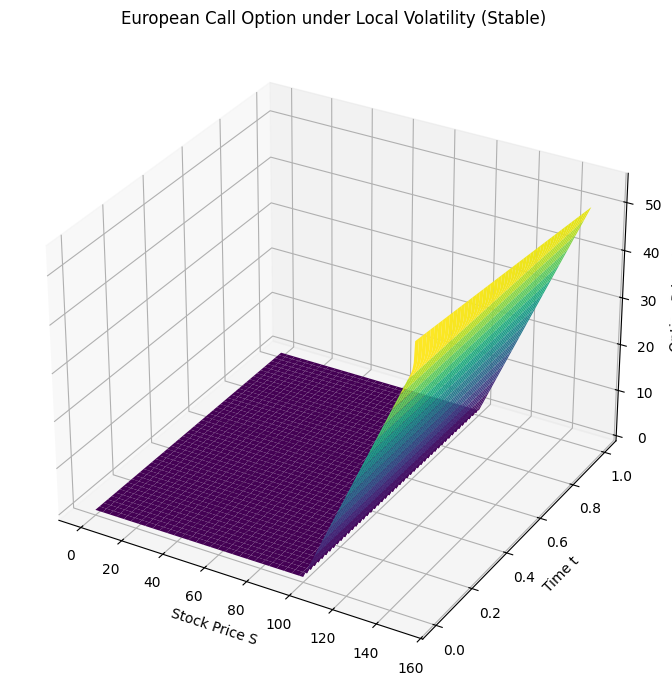

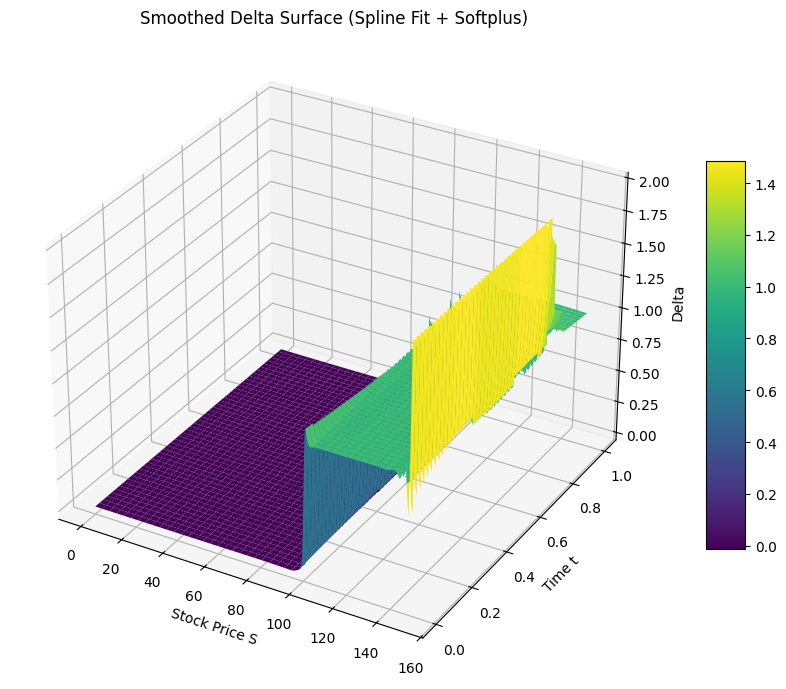

In [28]:
# graph
T_grid, S_grid = np.meshgrid(t, S)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, T_grid, solution.T, cmap='viridis')
ax.set_xlabel('Stock Price S')
ax.set_ylabel('Time t')
ax.set_zlabel('Option Price V')
ax.set_title('European Call Option under Local Volatility (Stable)')
plt.tight_layout()
plt.show()


# %%
from scipy.interpolate import UnivariateSpline
from mpl_toolkits.mplot3d import Axes3D

# initial spline
delta_spline = np.zeros_like(solution)
gamma_spline = np.zeros_like(solution)

# for each time layer t[n]，compute spline and take derivative
for n in range(N + 1):
    spline = UnivariateSpline(S, solution[n], s=0.5)  # s=0.5 control sommth
    delta_spline[n] = spline.derivative(n=1)(S)
    gamma_spline[n] = spline.derivative(n=2)(S)

# clip get rid of max
delta_spline = np.clip(delta_spline, -2, 2)
gamma_spline = np.clip(gamma_spline, -0.2, 0.5)

# create grid
T_grid, S_grid = np.meshgrid(t, S)

# draw Delta Surface
fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(S_grid, T_grid, delta_spline.T, cmap='viridis')
ax1.set_xlabel('Stock Price S')
ax1.set_ylabel('Time t')
ax1.set_zlabel('Delta')
ax1.set_title('Smoothed Delta Surface (Spline Fit + Softplus)')
fig1.colorbar(surf1, ax=ax1, shrink=0.6, aspect=10)
plt.tight_layout()
plt.show()
